In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [3]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_1176.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_3739.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_3738.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0930.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_2667.jpg'] 

[0, 1, 1, 1, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


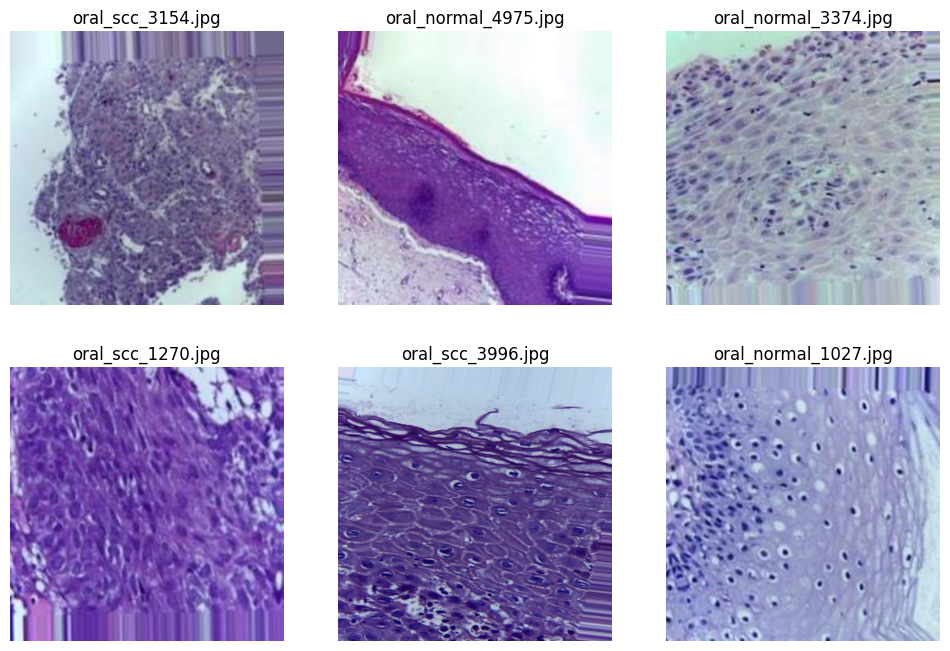

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:08<00:00, 101.79it/s]

Mean: tensor([0.5535, 0.5152, 0.7289])
Std: tensor([0.1618, 0.1925, 0.1223])


In [7]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_phase1_path = "best_cnn_phase1.pth"
model_final_path = "best_cnn_final.pth"



class OralCancerCNN(nn.Module):
    def __init__(self):
        super(OralCancerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2) 
        
        self.flatten_size = 256 * 14 * 14
        
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(512, 2)   
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, self.flatten_size) 
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = OralCancerCNN().to(device)

LR = 0.001
EPOCH = 25

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history_p1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        train_pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    history_p1['train_loss'].append(epoch_train_loss)
    history_p1['train_acc'].append(epoch_train_acc.item()) 
    history_p1['val_loss'].append(epoch_val_loss)
    history_p1['val_acc'].append(epoch_val_acc.item())  

    print(f"   Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存最佳模型
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), model_phase1_path)
        print(f"   New Best Model Saved! Val Acc: {best_val_acc:.4f}")



Epoch 1/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.70it/s, loss=0.5370]


   Train Loss: 1.5242 Acc: 0.6576 | Val Loss: 0.5691 Acc: 0.6800
   New Best Model Saved! Val Acc: 0.6800


Epoch 2/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.75it/s, loss=0.5328]


   Train Loss: 0.5437 Acc: 0.7259 | Val Loss: 0.5184 Acc: 0.7400
   New Best Model Saved! Val Acc: 0.7400


Epoch 3/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.78it/s, loss=0.5112]


   Train Loss: 0.5202 Acc: 0.7431 | Val Loss: 0.5001 Acc: 0.7487
   New Best Model Saved! Val Acc: 0.7487


Epoch 4/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s, loss=0.7037]


   Train Loss: 0.5138 Acc: 0.7580 | Val Loss: 0.5035 Acc: 0.7587
   New Best Model Saved! Val Acc: 0.7587


Epoch 5/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s, loss=0.4330]


   Train Loss: 0.5019 Acc: 0.7633 | Val Loss: 0.4304 Acc: 0.7960
   New Best Model Saved! Val Acc: 0.7960


Epoch 6/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.65it/s, loss=0.4183]


   Train Loss: 0.4898 Acc: 0.7637 | Val Loss: 0.4243 Acc: 0.7967
   New Best Model Saved! Val Acc: 0.7967


Epoch 7/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s, loss=0.5408]


   Train Loss: 0.4919 Acc: 0.7703 | Val Loss: 0.5272 Acc: 0.7200


Epoch 8/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s, loss=0.5461]


   Train Loss: 0.4717 Acc: 0.7760 | Val Loss: 0.4595 Acc: 0.7713


Epoch 9/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s, loss=0.4941]


   Train Loss: 0.4794 Acc: 0.7674 | Val Loss: 0.4204 Acc: 0.7980
   New Best Model Saved! Val Acc: 0.7980


Epoch 10/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s, loss=0.5369]


   Train Loss: 0.4566 Acc: 0.7880 | Val Loss: 0.4107 Acc: 0.8120
   New Best Model Saved! Val Acc: 0.8120


Epoch 11/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s, loss=0.3634]


   Train Loss: 0.4702 Acc: 0.7730 | Val Loss: 0.4279 Acc: 0.7840


Epoch 12/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s, loss=0.4439]


   Train Loss: 0.4583 Acc: 0.7806 | Val Loss: 0.3913 Acc: 0.8100


Epoch 13/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.75it/s, loss=0.6100]


   Train Loss: 0.4455 Acc: 0.7864 | Val Loss: 0.4362 Acc: 0.7947


Epoch 14/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s, loss=0.3673]


   Train Loss: 0.4400 Acc: 0.7947 | Val Loss: 0.3573 Acc: 0.8400
   New Best Model Saved! Val Acc: 0.8400


Epoch 15/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s, loss=0.4370]


   Train Loss: 0.4344 Acc: 0.8029 | Val Loss: 0.3251 Acc: 0.8433
   New Best Model Saved! Val Acc: 0.8433


Epoch 16/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s, loss=0.3801]


   Train Loss: 0.4279 Acc: 0.8007 | Val Loss: 0.3649 Acc: 0.8287


Epoch 17/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.77it/s, loss=0.6145]


   Train Loss: 0.3939 Acc: 0.8124 | Val Loss: 0.3501 Acc: 0.8247


Epoch 18/25 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s, loss=0.8501]


   Train Loss: 0.4104 Acc: 0.8106 | Val Loss: 0.3628 Acc: 0.8093


Epoch 19/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s, loss=0.4031]


   Train Loss: 0.3989 Acc: 0.8129 | Val Loss: 0.3418 Acc: 0.8273


Epoch 20/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s, loss=0.2603]


   Train Loss: 0.3950 Acc: 0.8159 | Val Loss: 0.3232 Acc: 0.8560
   New Best Model Saved! Val Acc: 0.8560


Epoch 21/25 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s, loss=0.2646]


   Train Loss: 0.3986 Acc: 0.8163 | Val Loss: 0.3620 Acc: 0.8160


Epoch 22/25 [Train]: 100%|██████████| 219/219 [00:56<00:00,  3.89it/s, loss=0.3659]


   Train Loss: 0.3795 Acc: 0.8223 | Val Loss: 0.3167 Acc: 0.8487


Epoch 23/25 [Train]: 100%|██████████| 219/219 [00:56<00:00,  3.86it/s, loss=0.4368]


   Train Loss: 0.3640 Acc: 0.8300 | Val Loss: 0.2828 Acc: 0.8687
   New Best Model Saved! Val Acc: 0.8687


Epoch 24/25 [Train]: 100%|██████████| 219/219 [00:56<00:00,  3.85it/s, loss=0.4695]


   Train Loss: 0.3609 Acc: 0.8380 | Val Loss: 0.2747 Acc: 0.8780
   New Best Model Saved! Val Acc: 0.8780


Epoch 25/25 [Train]: 100%|██████████| 219/219 [00:56<00:00,  3.84it/s, loss=0.3385]


   Train Loss: 0.3515 Acc: 0.8429 | Val Loss: 0.2610 Acc: 0.8733



  Phase 1 Learning Curve:


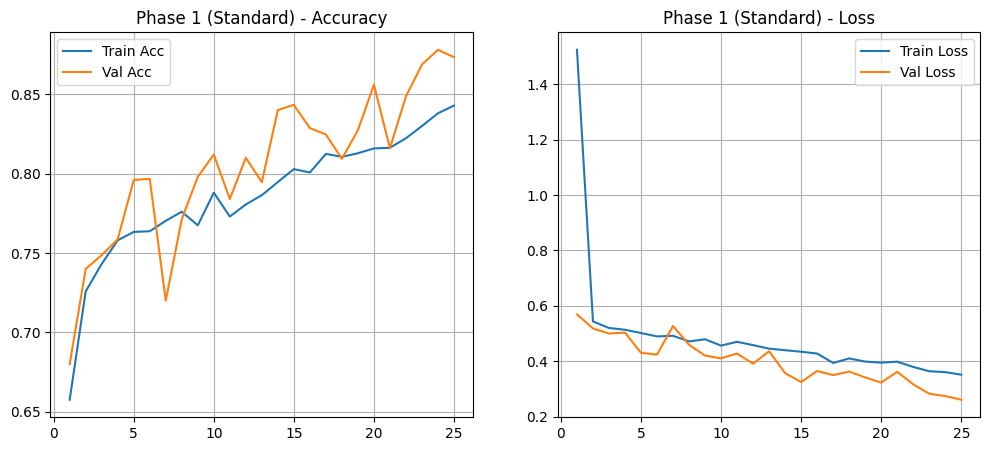

In [13]:
def plot_history(history, title):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend(); plt.grid(True)
    plt.show()

print("\n  Phase 1 Learning Curve:")
plot_history(history_p1, "Phase 1 (Standard)")

P2 Epoch 1/20: 100%|██████████| 266/266 [00:36<00:00,  7.27it/s, loss=0.235]


   Acc: Train (Full) 0.8566 | Val (Test Set) 0.8753
   Phase 2 Best Model Saved! Test Acc: 0.8753


P2 Epoch 2/20: 100%|██████████| 266/266 [00:31<00:00,  8.39it/s, loss=0.221]


   Acc: Train (Full) 0.8642 | Val (Test Set) 0.8780
   Phase 2 Best Model Saved! Test Acc: 0.8780


P2 Epoch 3/20: 100%|██████████| 266/266 [00:32<00:00,  8.15it/s, loss=0.369]


   Acc: Train (Full) 0.8648 | Val (Test Set) 0.8813
   Phase 2 Best Model Saved! Test Acc: 0.8813


P2 Epoch 4/20: 100%|██████████| 266/266 [00:32<00:00,  8.16it/s, loss=0.11] 


   Acc: Train (Full) 0.8711 | Val (Test Set) 0.8840
   Phase 2 Best Model Saved! Test Acc: 0.8840


P2 Epoch 5/20: 100%|██████████| 266/266 [00:32<00:00,  8.30it/s, loss=0.378]


   Acc: Train (Full) 0.8682 | Val (Test Set) 0.8800


P2 Epoch 6/20: 100%|██████████| 266/266 [00:32<00:00,  8.29it/s, loss=0.286] 


   Acc: Train (Full) 0.8740 | Val (Test Set) 0.8820


P2 Epoch 7/20: 100%|██████████| 266/266 [00:31<00:00,  8.34it/s, loss=0.304]


   Acc: Train (Full) 0.8771 | Val (Test Set) 0.8807


P2 Epoch 8/20: 100%|██████████| 266/266 [00:30<00:00,  8.72it/s, loss=0.505]


   Acc: Train (Full) 0.8712 | Val (Test Set) 0.8833


P2 Epoch 9/20: 100%|██████████| 266/266 [00:30<00:00,  8.67it/s, loss=0.489]


   Acc: Train (Full) 0.8749 | Val (Test Set) 0.8780


P2 Epoch 10/20: 100%|██████████| 266/266 [00:30<00:00,  8.64it/s, loss=0.253] 


   Acc: Train (Full) 0.8718 | Val (Test Set) 0.8833


P2 Epoch 11/20: 100%|██████████| 266/266 [00:30<00:00,  8.78it/s, loss=0.257] 


   Acc: Train (Full) 0.8818 | Val (Test Set) 0.8873
   Phase 2 Best Model Saved! Test Acc: 0.8873


P2 Epoch 12/20: 100%|██████████| 266/266 [00:30<00:00,  8.77it/s, loss=0.349]


   Acc: Train (Full) 0.8801 | Val (Test Set) 0.8853


P2 Epoch 13/20: 100%|██████████| 266/266 [00:30<00:00,  8.66it/s, loss=0.357]


   Acc: Train (Full) 0.8779 | Val (Test Set) 0.8820


P2 Epoch 14/20: 100%|██████████| 266/266 [00:31<00:00,  8.52it/s, loss=0.485]


   Acc: Train (Full) 0.8821 | Val (Test Set) 0.8827


P2 Epoch 15/20: 100%|██████████| 266/266 [00:30<00:00,  8.84it/s, loss=0.176] 


   Acc: Train (Full) 0.8848 | Val (Test Set) 0.8867


P2 Epoch 16/20: 100%|██████████| 266/266 [00:30<00:00,  8.81it/s, loss=0.254] 


   Acc: Train (Full) 0.8824 | Val (Test Set) 0.8900
   Phase 2 Best Model Saved! Test Acc: 0.8900


P2 Epoch 17/20: 100%|██████████| 266/266 [00:30<00:00,  8.85it/s, loss=0.222] 


   Acc: Train (Full) 0.8852 | Val (Test Set) 0.8873


P2 Epoch 18/20: 100%|██████████| 266/266 [00:29<00:00,  8.88it/s, loss=0.307] 


   Acc: Train (Full) 0.8805 | Val (Test Set) 0.8913
   Phase 2 Best Model Saved! Test Acc: 0.8913


P2 Epoch 19/20: 100%|██████████| 266/266 [00:30<00:00,  8.66it/s, loss=0.147] 


   Acc: Train (Full) 0.8805 | Val (Test Set) 0.8920
   Phase 2 Best Model Saved! Test Acc: 0.8920


P2 Epoch 20/20: 100%|██████████| 266/266 [00:30<00:00,  8.74it/s, loss=0.201] 


   Acc: Train (Full) 0.8867 | Val (Test Set) 0.8840

  Phase 2 Learning Curve :


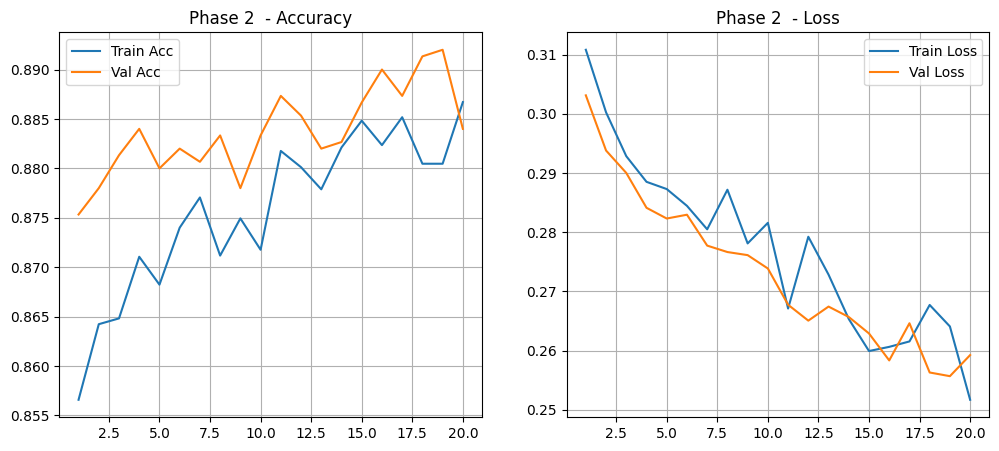

In [14]:
full_train_dataset = ConcatDataset([train_dataset, val_dataset])
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(model_phase1_path))


EPOCH_PHASE2 = 20

optimizer = optim.Adam(model.parameters(), lr=0.00001) 

history_p2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_test_acc = 0.0

for epoch in range(EPOCH_PHASE2):
    model.train()
    train_loss, train_corrects = 0.0, 0
    pbar = tqdm(full_train_loader, desc=f"P2 Epoch {epoch+1}/{EPOCH_PHASE2}")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        pbar.set_postfix({'loss': loss.item()})
        
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)


    e_train_acc = (train_corrects.double() / len(full_train_dataset)).item()
    e_val_acc = (val_corrects.double() / len(test_dataset)).item()
    
    history_p2['train_loss'].append(train_loss/len(full_train_dataset))
    history_p2['train_acc'].append(e_train_acc)
    history_p2['val_loss'].append(val_loss/len(test_dataset))
    history_p2['val_acc'].append(e_val_acc)

    print(f"   Acc: Train (Full) {e_train_acc:.4f} | Val (Test Set) {e_val_acc:.4f}")

    if e_val_acc > best_test_acc:
        best_test_acc = e_val_acc
        torch.save(model.state_dict(), model_final_path)
        print(f"   Phase 2 Best Model Saved! Test Acc: {best_test_acc:.4f}")

print("\n  Phase 2 Learning Curve :")
plot_history(history_p2, "Phase 2 ")

Generating Metrics: 100%|██████████| 47/47 [00:09<00:00,  4.80it/s]



  Custom CNN Final Results
Accuracy  : 0.8920
Precision : 0.9298
Recall    : 0.8480
F1 Score  : 0.8870
------------------------------
              precision    recall  f1-score   support

      Normal       0.86      0.94      0.90       750
         SCC       0.93      0.85      0.89       750

    accuracy                           0.89      1500
   macro avg       0.90      0.89      0.89      1500
weighted avg       0.90      0.89      0.89      1500



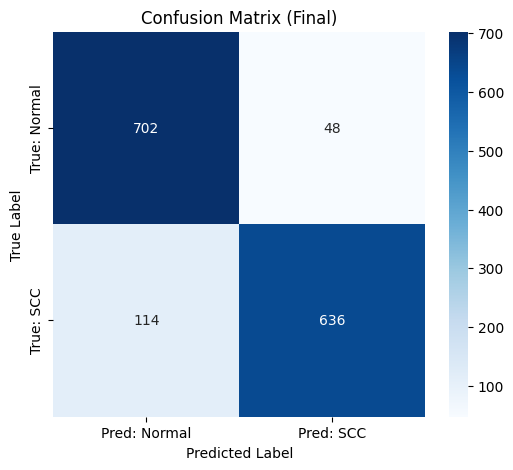

In [16]:

model.load_state_dict(torch.load(model_final_path))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating Metrics"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


acc = accuracy_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds, average='binary')
prec = precision_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\n" + "="*30)
print(f"  Custom CNN Final Results")
print("="*30)
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)

print(classification_report(all_labels, all_preds, target_names=['Normal', 'SCC']))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: SCC'],
            yticklabels=['True: Normal', 'True: SCC'])
plt.title('Confusion Matrix (Final)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()